# Quantitative Easing and Tapering
In response to the financial crisis of 2008, since March 2009 the Fed has been playing an active role in buying large quantities of federal debt and mortgage bonds and holding them on its books thereby increasing the monetary base (each purchase triggering an increase in reserve balances) and applying downward pressure on long-term interest rates. This process has become known as _quantitiative easing_. As a result, the percentage of US federal debt held by US federal reserve banks increased from about 8% in 2007 to a whopping 20.8% in 2021.

Since June 2022 the Fed has embarked on a tapering exercise whereby it allowed upto USD 30 billion in Treasury and USD 17.5 billion in mortgage bonds to mature every month without reinvesting the proceeds (a passive _runoff_, aka quantitative tightening). Each maturing bond whose notional the Fed is not reinvesting decreases the amount of reserves and hence the monetary base. In September 2022 the Fed increased the runoff to upto USD 60 billion in Treasuries and USD 35 billion in mortgage bonds.

In this notebook I examine the composition of securities held outright by the Fed as well its speed of increasing or decreasing them (in Billions per month).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

# Limit the display of dataframes to 25 rows max
pd.options.display.max_rows = 25

# Indicate representation in Billions
pd.options.display.float_format = '${:,.2f}bn'.format

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org) for this analysis:
* `WSHOTSL` &mdash; Assets: Securities Held Outright: U.S. Treasury Securities: Wednesday Level (weekly frequency)
* `WSHOMCB` &mdash; Assets: Securities Held Outright: Mortgage-Backed Securities: Wednesday Level (weekly frequency)
* `WSHOFADSL` &mdash; Assets: Securities Held Outright: Federal Agency Debt Securities: Wednesday Level (weekly frequency)

**NB:** These data series return the face value of these securities. The unamortied differences between the face value and the purchase price is held in the _Unamortized premiums on securities held outright_ and _Unamortized discounts on securities held outright_ accounts (which can be obtained from the `WUPSHO` and `WUDSHO` series respectively).

In [3]:
sec_held_outright = web.get_data_fred(['WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL'],
                                      start=report_start, end=report_end).asfreq('W-Wed')

# Converting into billions of USD
sec_held_outright /= 1000.

In [4]:
sec_held_outright.rename(
    columns={'WSHOTSL': 'US Treasury Securities', 'WSHOMCB': 'Mortgage-Backed Securities',
             'WSHOFADSL': 'Federal Agency Debt Securities', 'WLCFLL': 'Loans'},
    inplace=True)

In [5]:
SEC_HELD_OUTRIGHT_COMPOSITION_TITLE = 'Federal Reserve Banks: Securities held outright (at face value)'
SEC_HELD_OUTRIGHT_SPEED = 'Speed of Quantitative Easing or Tapering in Billions of USD per month'
SEC_HELD_OUTRIGHT_SPEED_MA = 'Speed of Quantitative Easing or Tapering in Billions of USD per month (moving average over one quarter)'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
LEFT_Y_AXIS_LABEL_SPEED = 'Billions of USD per Month'

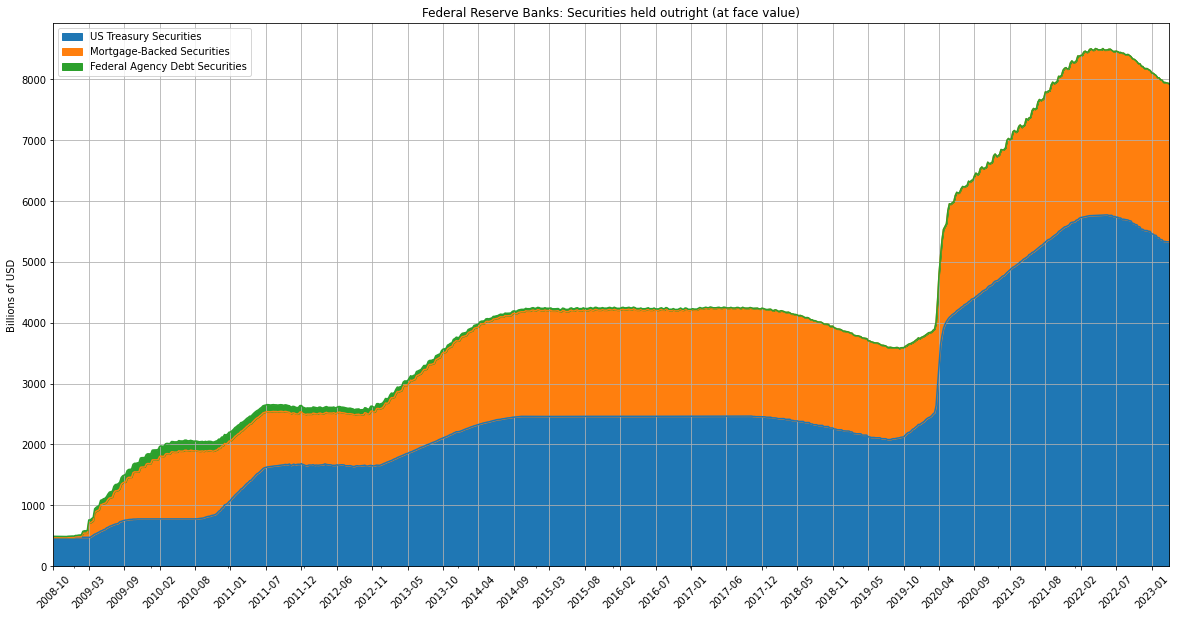

In [6]:
ax = sec_held_outright.iloc[:,:3].plot.area(figsize=(20,10), grid=True, title=SEC_HELD_OUTRIGHT_COMPOSITION_TITLE,
                          xticks=sec_held_outright.index[::24], xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL) #, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright.index[::24])))

In [7]:
# Resampling to month start
sec_held_outright = sec_held_outright.resample('MS').last()

In [8]:
sec_held_outright

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans
DATE,,,,
2008-10-01,$476.47bn,$0.00bn,$13.62bn,$369.76bn
2008-11-01,$476.41bn,$0.00bn,$12.22bn,$259.05bn
2008-12-01,$475.92bn,$0.00bn,$19.71bn,$193.87bn
2009-01-01,$475.13bn,$7.38bn,$28.36bn,$154.79bn
2009-02-01,$474.64bn,$68.75bn,$38.34bn,$138.90bn
...,...,...,...,...
2022-11-01,"$5,515.98bn","$2,658.76bn",$2.35bn,$22.33bn
2022-12-01,"$5,500.83bn","$2,641.40bn",$2.35bn,$16.13bn
2023-01-01,"$5,435.58bn","$2,624.74bn",$2.35bn,$16.29bn


### Measuring the speed of quantitative easing/tapering in Billions of USD per month

In [9]:
sec_held_outright_speed = (sec_held_outright - sec_held_outright.shift(1)).dropna()

In [10]:
sec_held_outright_speed.loc['2020-01':, sec_held_outright_speed.columns[[0,1,3]]].tail(12)

,US Treasury Securities,Mortgage-Backed Securities,Loans
DATE,,,
2022-04-01,$3.98bn,$-0.24bn,$0.68bn
2022-05-01,$5.40bn,$-7.57bn,$-3.59bn
2022-06-01,$-5.48bn,$1.88bn,$0.58bn
2022-07-01,$-29.75bn,$8.05bn,$-1.52bn
2022-08-01,$-39.18bn,$-8.09bn,$0.09bn
2022-09-01,$-23.15bn,$-11.13bn,$0.29bn
2022-10-01,$-63.11bn,$-19.64bn,$-1.54bn
2022-11-01,$-92.75bn,$-19.76bn,$3.31bn
2022-12-01,$-15.15bn,$-17.35bn,$-6.20bn


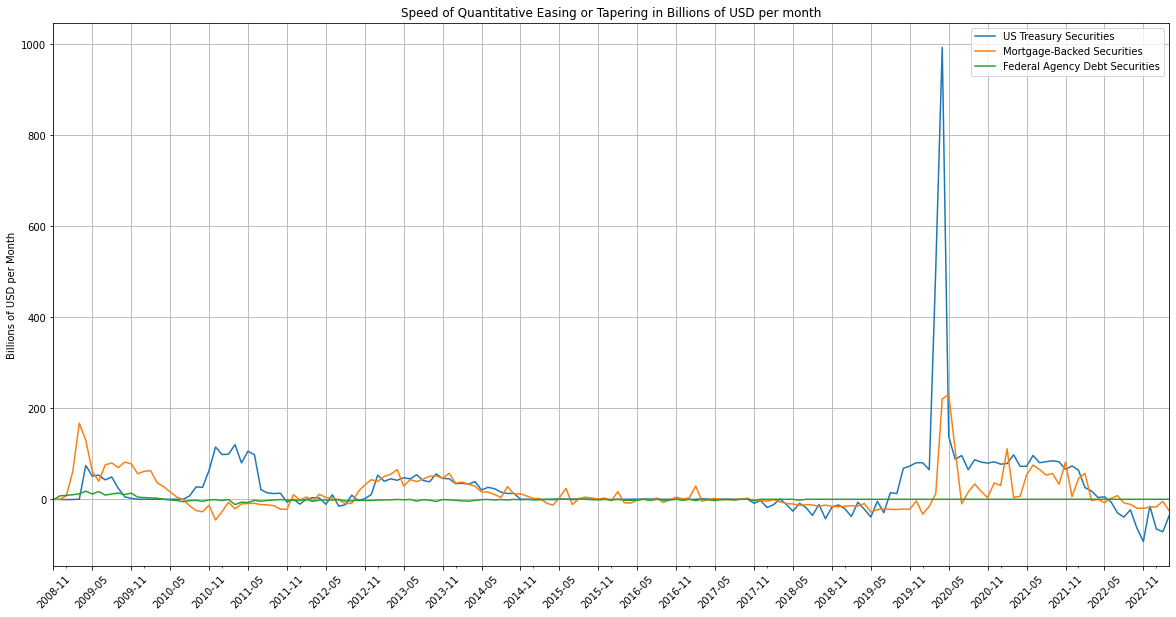

In [11]:
ax = sec_held_outright_speed.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED,
                            xticks=sec_held_outright_speed.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)#, yticks=np.arange(-30, 21, 5))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed.index[::6])))

##### Limiting the range of the Y axis for better display

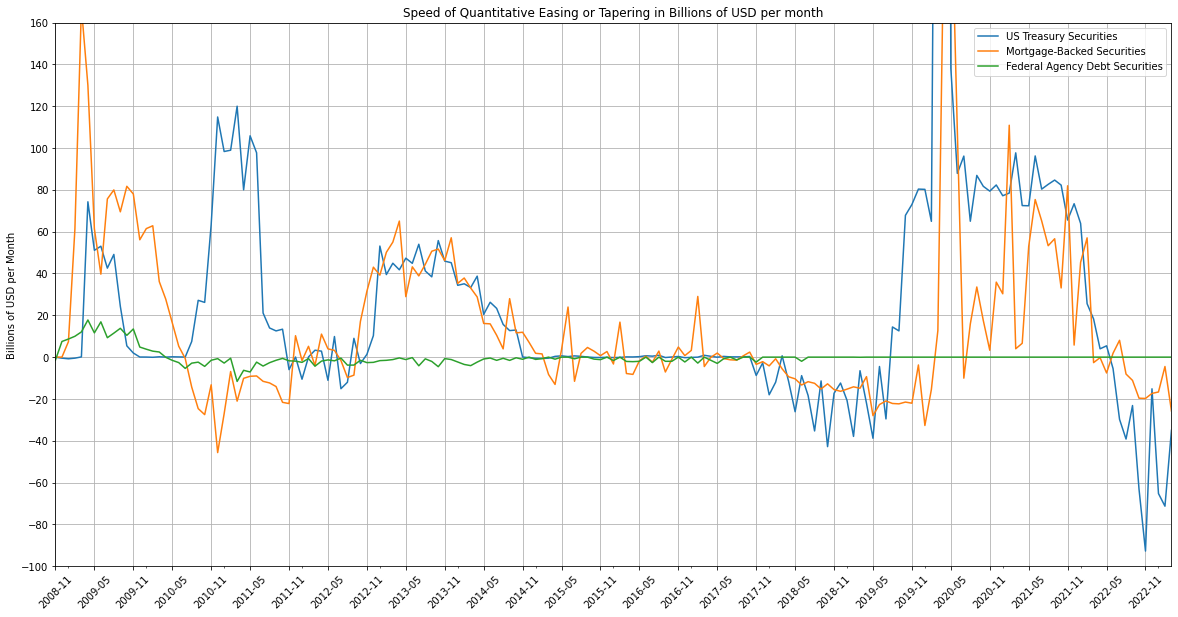

In [12]:
ax = sec_held_outright_speed.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED,
                            xticks=sec_held_outright_speed.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED, ylim=(-100, 160), yticks=np.arange(-100, 161, 20))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed.index[::6])))

#### Zomming in on the last two years

In [13]:
sec_held_outright_speed_short = sec_held_outright_speed.loc['2021':]

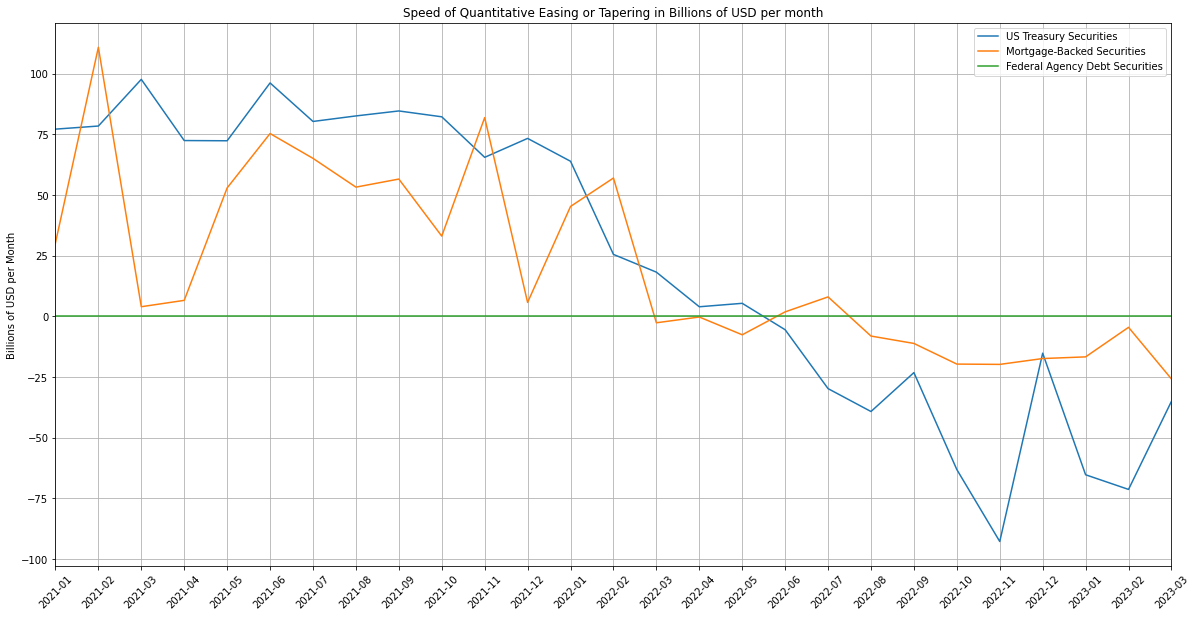

In [14]:
ax = sec_held_outright_speed_short.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED,
                            xticks=sec_held_outright_speed_short.index, xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)#, ylim=(-100, 200), yticks=np.arange(-100, 200, 20))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_short.index)))

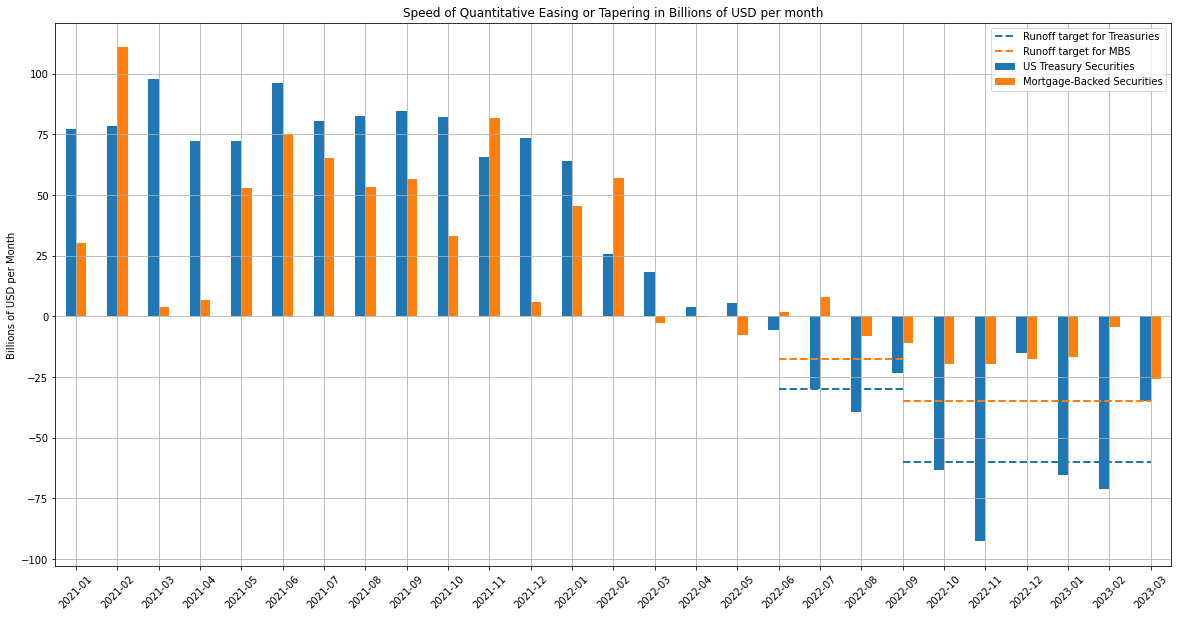

In [15]:
# Determine the index positions of the dates related to quantitative tightening
x1, x2 = sec_held_outright_speed_short.index.get_indexer(['2022-06', '2022-09'])

ax = sec_held_outright_speed_short.iloc[:,[0,1]].plot.bar(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)
# Translate them into coordinates
ax.hlines(y=[-30, -60], xmin=[x1, x2], xmax=[x2, sec_held_outright_speed_short.index.size-1],
          linestyles='--', lw=2, colors='#1f77b4', label='Runoff target for Treasuries')
ax.hlines(y=[-17.5, -35], xmin=[x1, x2], xmax=[x2, sec_held_outright_speed_short.index.size-1],
          linestyles='--', lw=2, colors='#ff7f0e', label='Runoff target for MBS')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_short.index)))

#### Measuring the speed of quantitative easing/tapering in Billions of USD/month represented as a moving average over one quarter

In [16]:
sec_held_outright_speed_ma = sec_held_outright_speed.rolling(3).mean().dropna()

In [17]:
sec_held_outright_speed_ma.loc['2020-01':, sec_held_outright_speed_ma.columns[:2]]

,US Treasury Securities,Mortgage-Backed Securities
DATE,,
2020-01-01,$77.87bn,$-19.49bn
2020-02-01,$75.19bn,$-17.29bn
2020-03-01,$216.50bn,$-11.81bn
2020-04-01,$520.77bn,$72.48bn
2020-05-01,$545.15bn,$154.42bn
...,...,...
2022-11-01,$-59.67bn,$-16.84bn
2022-12-01,$-57.00bn,$-18.92bn
2023-01-01,$-57.72bn,$-17.93bn


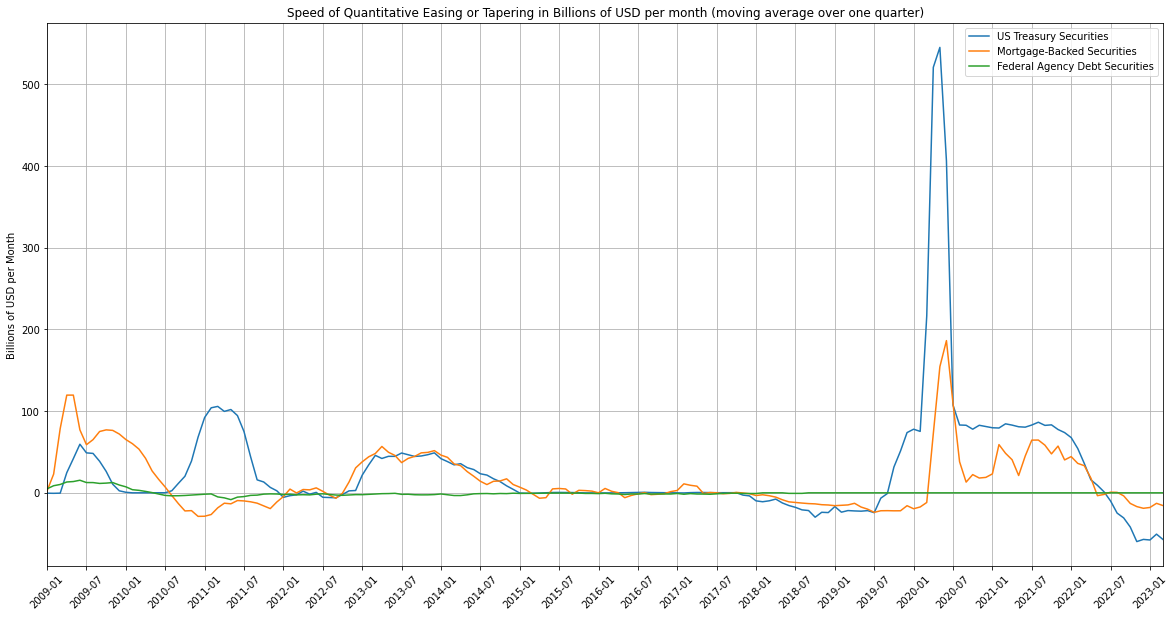

In [18]:
ax = sec_held_outright_speed_ma.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED_MA,
                            xticks=sec_held_outright_speed_ma.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)#, yticks=np.arange(-30, 21, 5))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_ma.index[::6])))

##### Limiting the range of the Y axis for better display.

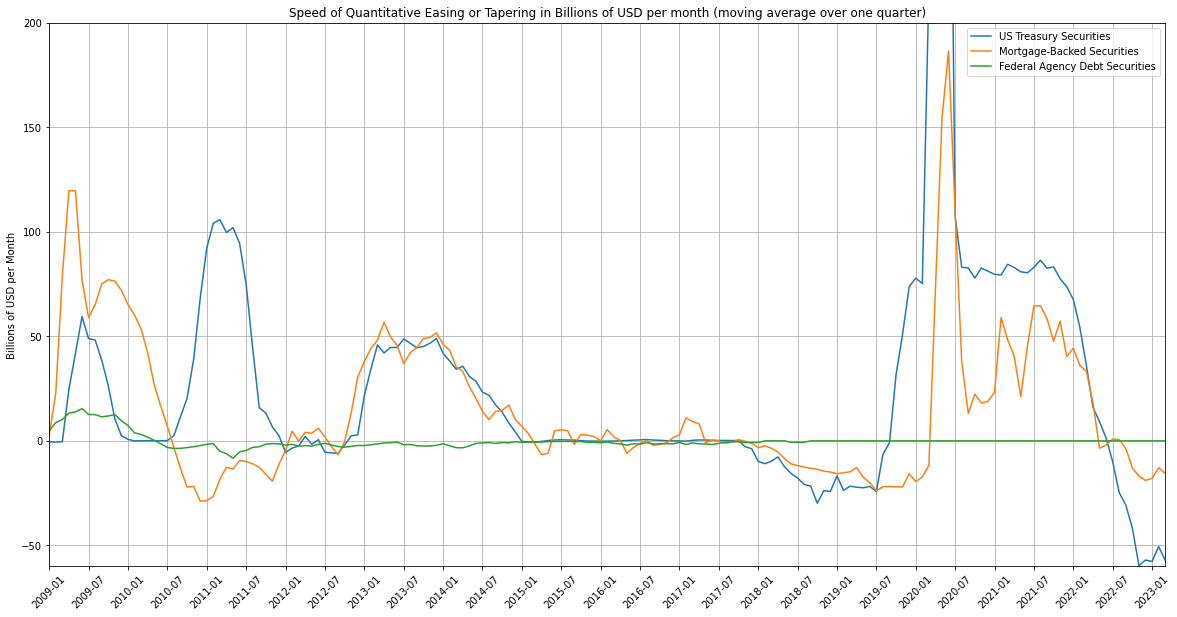

In [19]:
ax = sec_held_outright_speed_ma.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED_MA,
                            xticks=sec_held_outright_speed_ma.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED, ylim=(-60, 200))#, yticks=np.arange(-30, 21, 5))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_ma.index[::6])))

#### Zomming in on the last two years

In [20]:
sec_held_outright_speed_ma_short = sec_held_outright_speed_ma.loc['2021':]

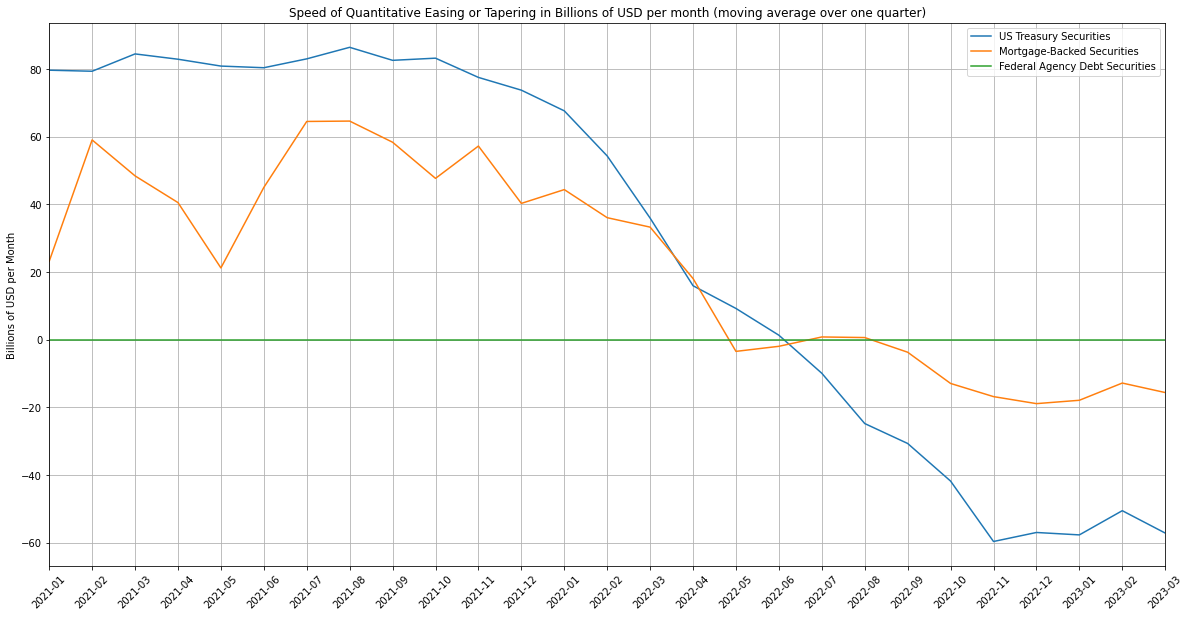

In [21]:
ax = sec_held_outright_speed_ma_short.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED_MA,
                            xticks=sec_held_outright_speed_ma_short.index, xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_ma_short.index)))

In [22]:
# Resampling to quarter start
sec_held_outright_2 = sec_held_outright.resample('QS').last()

In [23]:
sec_held_outright_2

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans
DATE,,,,
2008-10-01,$475.92bn,$0.00bn,$19.71bn,$193.87bn
2009-01-01,$474.75bn,$236.16bn,$50.39bn,$136.23bn
2009-04-01,$653.19bn,$467.23bn,$96.63bn,$132.66bn
2009-07-01,$769.16bn,$692.37bn,$131.18bn,$110.33bn
2009-10-01,$776.59bn,$908.26bn,$159.88bn,$89.70bn
...,...,...,...,...
2022-01-01,"$5,760.03bn","$2,715.25bn",$2.35bn,$24.03bn
2022-04-01,"$5,763.93bn","$2,709.33bn",$2.35bn,$21.70bn
2022-07-01,"$5,671.85bn","$2,698.16bn",$2.35bn,$20.56bn


In [24]:
sec_held_outright_speed_2 = (sec_held_outright_2 - sec_held_outright_2.shift(1)).dropna()

In [25]:
sec_held_outright_speed_2

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans
DATE,,,,
2009-01-01,$-1.18bn,$236.16bn,$30.69bn,$-57.65bn
2009-04-01,$178.45bn,$231.07bn,$46.23bn,$-3.57bn
2009-07-01,$115.97bn,$225.14bn,$34.55bn,$-22.33bn
2009-10-01,$7.43bn,$215.89bn,$28.70bn,$-20.63bn
2010-01-01,$0.12bn,$160.44bn,$9.11bn,$-8.99bn
...,...,...,...,...
2022-01-01,$107.76bn,$99.76bn,$0.00bn,$-10.92bn
2022-04-01,$3.90bn,$-5.92bn,$0.00bn,$-2.33bn
2022-07-01,$-92.09bn,$-11.17bn,$0.00bn,$-1.14bn


In [26]:
sec_held_outright_speed_2.sum(axis=1)

DATE
2009-01-01    $208.02bn
2009-04-01    $452.18bn
2009-07-01    $353.33bn
2009-10-01    $231.39bn
2010-01-01    $160.68bn
                ...    
2022-01-01    $196.60bn
2022-04-01     $-4.35bn
2022-07-01   $-104.40bn
2022-10-01   $-232.20bn
2023-01-01    $108.08bn
Freq: QS-JAN, Length: 57, dtype: float64